# Tone Classification
We're gonna try to classify the tone of audio samples... I'm not very experienced with classifying human speech, so for reference, I'm using these blog posts:  


* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505
* https://towardsdatascience.com/audio-deep-learning-made-simple-part-3-data-preparation-and-augmentation-24c6e1f6b52


I'm not copy-pasting code or using the methods out-of-the-box unless otherwise noted in a comment, but I am following (most of) the methods in the blog post


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
import os
import torchaudio
import librosa

# Build Dataset
This only has to run once.

In [ ]:
# unzip data
!unzip "/content/drive/My Drive/Summer 2022/Misc/tone_perfect.zip" -d "/content/drive/My Drive/Summer 2022/Misc/tone_perfect"

In [ ]:
# Iterate through data directory and load each piece of data
# This prints out a ton of warnings which is very annoying
DATAPATH = "/content/drive/My Drive/Summer 2022/Misc/tone_perfect"
waveforms = []
sample_rates = []
fnames = []

for fname in os.listdir(DATAPATH):
  signal, sr = librosa.load(os.path.join(DATAPATH, fname))
  waveforms.append(signal)
  sample_rates.append(sr)
  fnames.append(fname)

In [ ]:
print("Number of training samples: {0}".format(len(fnames))) # Ok this is pretty small, doesn't take up much RAM. We'll just save it in a nice npz format
print(set(sample_rates)) # and all of our sample rates are 22050! yay!
print(set([w.shape for w in waveforms])) # lots of diferent lengths though... we can start by padding with silence, I guess
print(set([len(w.shape) for w in waveforms])) # but no stereo, this is good

Number of training samples: 2535
{22050}
{(24216,), (21912,), (22488,), (16728,), (11544,), (15000,), (18456,), (17304,), (12696,), (16152,), (10392,), (13848,), (8088,), (19608,), (10968,), (8664,), (5208,), (27672,), (25368,), (28248,), (25944,), (3262,), (6360,), (28824,), (23064,), (14424,), (17880,), (12120,), (15576,), (24792,), (19032,), (13272,), (7512,), (9816,), (20184,), (20760,), (23640,), (26520,), (9240,), (27096,), (21336,), (29400,), (6936,)}
{1}


In [ ]:

# Cool, so we'll just make an npz with attributes: waves, tones, words, genders
words = list(map(lambda x: x.split('_')[0][:-1], fnames))
tones = list(map(lambda x: int(eval(x.split('_')[0][-1])), fnames))
genders = list(map(lambda x: x.split('_')[1][:-1], fnames)) #either "MV" or "FV"

np.savez("/content/drive/My Drive/Summer 2022/Misc/tone_data.npz", words=words, tones=tones, genders=genders, waves=waveforms, allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Prepare Data for Training

In [ ]:
# Load our prebuilt dataset
ds = np.load("/content/drive/My Drive/Summer 2022/Misc/tone_data.npz", allow_pickle=True)
words = ds['words']
tones = ds['tones']
genders = ds['genders']
waves = ds['waves']

print('Unique words: {0}, unique tones: {1}'.format(len(set(words)), len(set(tones))))


Unique words: 410, unique tones: 4


In [ ]:
# Make our data nicely scaled
print(np.min(waves[0]))
print(np.max(waves[0]))
print(waves[0].dtype)
tones = np.asarray(tones) - 1

# looks like waves are already in a nice format: scaled -1 to 1

-0.824107
0.9873464
float32


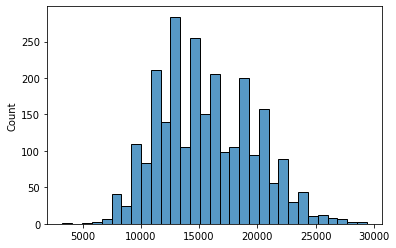

In [ ]:
# to decide on a max sequence length, we'll histogram the sequence lengths
import seaborn as sns
sns.histplot([x.shape[0] for x in waves])
# looks like we'll go with 25k

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchaudio import transforms
# To start, we'll ignore the word and just pass wave as input, tone as output
# We could do our preprocessing ahead of time... but if we want to do
# data augmentation, we're going to have to do stuff at runtime, so I'll just make everything happen at runtime

seq_len = 25000
device = 'cuda:0'

# spectrogram hyperparams
top_db = 80
n_mels = 64
n_fft = 1024
hop_length = None

class ToneDS(Dataset):
  def __init__(self, waves, tones):
    self.waves = waves
    self.tones = tones
  
  def __len__(self):
    return self.tones.shape[0]

  def __getitem__(self, idx):
    wave = self.waves[idx]

    # padding/truncation
    size = wave.shape[0]
    wave = torch.tensor(wave)
    if size>=seq_len:
      wave = (wave[:seq_len])
    
    else:
      wave = torch.cat([wave, torch.zeros(seq_len - size)], dim=0)

    wave = wave.view(1, seq_len) # give it one channel
    # if we ever to any data augmentation, it will go here


    # Spectrogram time (COPIED FROM BLOG POST B/C I HAVE NO IDEA HOW THIS WORKS)
    # SOMETIMES USING MFCC CAN BE BETTER APPARENTLY, BUT DIFFERENT SOURCES DISAGREE
    # I'LL GO SIMPLE AND USE THE MEL SPECTROGRAM

    # spec has shape [channel, n_mels, time], where channel is 1 in our case
    spec = transforms.MelSpectrogram(22050, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(wave)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)

    return spec.to(device), self.tones[idx]

In [ ]:
# Now actually construct the datasets and dataloaders
dataset = ToneDS(waves, tones)

# 80/20 trainval split
train_size = int(len(dataset) * .8)
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# batch shape is [batch_size, 1, 64, 49]

In [ ]:
for batch in train_dl:
  print(batch[0].shape)

# Network Architecture and Training

In [ ]:
from functools import reduce

def conv_block(filter_size, channels_in, channels_out, stride):
  conv = nn.Conv2d(channels_in, channels_out, filter_size, stride=stride)
  ac = nn.ReLU()
  bn = nn.BatchNorm2d(channels_out)
  return [conv, ac, bn]

class ToneModel(nn.Module):
  def __init__(self, num_outputs = 4):
    super(ToneModel, self).__init__()

    conv_blocks = [
        conv_block(8, 1, 16, 2),
        conv_block(6, 16, 32, 2),
        conv_block(4, 32, 64, 1) 
    ]
    layers = reduce(lambda x,y: x+y, conv_blocks, [])
    layers.append(nn.Flatten())
    layers.append(nn.Linear(2880, 64))
    layers.append(nn.Tanh())
    layers.append(nn.Linear(64, num_outputs))

    self.model = nn.Sequential(*layers)
  def forward(self, inputs, return_logits = True):
    logits = self.model(inputs)
    if not return_logits:
      return torch.softmax(logits,dim=-1)
    else:
      return logits




In [ ]:
from tqdm import tqdm

# Now for our trainloop
def trainloop(model, dataloader, optimizer, loss_fnc, print_freq=10):
  loss_sum = 0
  for i, batch in tqdm(enumerate(dataloader)):
    model.train()
    inps = batch[0]
    inps.to(device)
    preds = model(inps)
    labels = torch.eye(4)[batch[1]]
    labels = labels.to(device)

    optimizer.zero_grad()
    loss = loss_fnc(preds, labels)

    loss.backward()
    optimizer.step()

    loss_sum+=loss
  return loss_sum

model = ToneModel().to(device)
loss_fnc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), .001)

for _ in range(15):
  l = trainloop(model, train_dl, optimizer, loss_fnc)
  print(l)


127it [00:02, 46.01it/s]


tensor(52.1414, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 39.74it/s]


tensor(12.9757, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 38.37it/s]


tensor(9.0832, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:02, 42.73it/s]


tensor(5.8739, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:04, 31.69it/s]


tensor(3.0998, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:02, 42.44it/s]


tensor(2.0944, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:02, 45.54it/s]


tensor(1.2747, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 38.38it/s]


tensor(6.4171, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 37.63it/s]


tensor(4.2092, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 40.89it/s]


tensor(1.0243, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:05, 25.25it/s]


tensor(0.8011, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:04, 30.65it/s]


tensor(0.3976, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:04, 29.46it/s]


tensor(0.2981, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:02, 47.12it/s]


tensor(0.2298, device='cuda:0', grad_fn=<AddBackward0>)


127it [00:03, 40.08it/s]

tensor(5.9002, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
# ok now for validation...

def valloop(model, dataloader):
  outputs = []
  labels = []
  for i, batch in tqdm(enumerate(dataloader)):
    model.eval()
    inps = batch[0]
    labels.append(batch[1].cpu().numpy())
    inps.to(device)
    preds = model(inps, return_logits=False)
    outputs.append(preds.detach().cpu().numpy())
  
  yhat = np.argmax(np.concatenate(outputs),axis=-1)
  labels = np.concatenate(labels)
  return yhat, labels

preds, labels = valloop(model, val_dl)

16it [00:00, 27.48it/s]


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy: {0}".format(accuracy_score(labels, preds)))

Accuracy: 0.9704142011834319
